In [42]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from tqdm.auto import tqdm
import glob
import os
import sys

# pip3 install --user PyMuPDF
import fitz

In [43]:
%%bash
# https://www.google.com/covid19/mobility/
mkdir -p pdfs/
cd pdfs/

states="Alabama Alaska Arizona Arkansas California Colorado Connecticut Delaware Florida Georgia Hawaii Idaho Illinois Indiana Iowa Kansas Kentucky Louisiana Maine Maryland Massachusetts Michigan Minnesota Mississippi Missouri Montana Nebraska Nevada New_Hampshire New_Jersey New_Mexico New_York North_Carolina North_Dakota Ohio Oklahoma Oregon Pennsylvania Rhode_Island South_Carolina South_Dakota Tennessee Texas Utah Vermont Virginia Washington West_Virginia Wisconsin Wyoming"
date="2020-04-05"
for state in $states ; do
    curl -s -O https://www.gstatic.com/covid19/mobility/${date}_US_${state}_Mobility_Report_en.pdf
done
# rename the full US pdf slightly to conform to similar naming convention as the individual states
curl -s -o ${date}_US_US_Mobility_Report_en.pdf https://www.gstatic.com/covid19/mobility/${date}_US_Mobility_Report_en.pdf

Process is interrupted.


In [44]:
def parse_stream(stream):
    data_raw = []
    data_transformed = []
    rotparams = None
    npatches = 0
    for line in stream.splitlines():
        if line.endswith(" cm"):
            # page 146 of https://www.adobe.com/content/dam/acom/en/devnet/pdf/pdfs/pdf_reference_archives/PDFReference.pdf
            rotparams = list(map(float,line.split()[:-1]))
        elif line.endswith(" l"):
            x,y = list(map(float,line.split()[:2]))
            a,b,c,d,e,f = rotparams
            xp = a*x+c*y+e
            yp = b*x+d*y+f
            data_transformed.append([xp,yp])
            data_raw.append([x,y])
        elif line.endswith(" m"):
            npatches += 1
        else:
            pass
    data_raw = np.array(data_raw)
    if len(data_raw) < 1:
        return dict(good=False)
    basex, basey = data_raw[-1]
    good = False
    if basex == 0.:
        data_raw[:,1] = basey - data_raw[:,1]
        data_raw[:,1] *= 100/60.
        data_raw = data_raw[data_raw[:,1]!=0.]
        if npatches == 1: good = True
    return dict(data=np.array(data_raw), npatches=npatches, good=good)

In [45]:
def parse_page(doc, ipage, verbose=False):
    categories = [
        "Retail & recreation",
        "Grocery & pharmacy",
        "Parks",
        "Transit stations",
        "Workplace",
        "Residential",
    ]
    if verbose:
        print(f"ipage: {ipage}")

    counties = []
    curr_county = None
    curr_category = None
    data = defaultdict(lambda: defaultdict(list))
    pagetext = doc.getPageText(ipage)
    lines = pagetext.splitlines()
    tickdates = list(filter(lambda x:len(x.split())==3, set(lines[-10:])))
    for line in lines:
        # don't need these lines at all
        if ("* Not enough data") in line: continue
        if ("needs a significant volume of data") in line: continue

        # if we encountered a category, add to dict, otherwise
        # push all seen lines into the existing dict entry
        if any(line.startswith(c) for c in categories):
            curr_category = line
        elif curr_category:
            data[curr_county][curr_category].append(line)

        # If it doesn't match anything, then it's a county name
        if (all(c not in line for c in categories)
            and ("compared to baseline" not in line)
            and ("Not enough data" not in line)
           ):
            # saw both counties already
            if len(data.keys()) == 2: break
            counties.append(line)
            curr_county = line

    newdata = {}
    for county in data:
        newdata[county] = {}
        for category in data[county]:
            # if the category text ends with a space, then there was a star/asterisk there
            # indicating lack of data. we skip these.
            if category.endswith(" "): continue
            temp = [x for x in data[county][category] if "compared to baseline" in x]
            if not temp: continue
            percent = int(temp[0].split()[0].replace("%",""))
            newdata[county][category.strip()] = percent
    data = newdata

    tomatch = []
    for county in counties:
        for category in categories:
            if category in data[county]:
                tomatch.append([county,category,data[county][category]])
    if verbose:
        print(len(tomatch))
        print(data)
    
    goodplots = []
    xrefs = sorted(doc.getPageXObjectList(ipage), key=lambda x:int(x[1].replace("X","")))
    for i,xref in enumerate(xrefs):
        stream = doc.xrefStream(xref[0]).decode()
        info = parse_stream(stream)
        if not info["good"]: continue
        goodplots.append(info)
    if verbose:
        print(len(goodplots))
    
    ret = []
    
    if len(tomatch) != len(goodplots):
        return ret
    
    
    for m,g in zip(tomatch,goodplots):
        xs = g["data"][:,0]
        ys = g["data"][:,1]
        maxys = ys[np.where(xs==xs.max())[0]]
        maxy = maxys[np.argmax(np.abs(maxys))]
        
        
        # parsed the tick date labels as text. find the min/max (first/last)
        # and make evenly spaced dates, one per day, to assign to x values between
        # 0 and 200 (the width of the plots).
        ts = list(map(lambda x: pd.Timestamp(x.split(None,1)[-1] + ", 2020"), tickdates))
        low, high = min(ts), max(ts)
        dr = list(map(lambda x:str(x).split()[0], pd.date_range(low, high, freq="D")))
        lutpairs = list(zip(np.linspace(0,200,len(dr)),dr))

        dates = []
        values = []
        asort = xs.argsort()
        xs = xs[asort]
        ys = ys[asort]
        for x,y in zip(xs,ys):
            date = min(lutpairs, key=lambda v:abs(v[0]-x))[1]
            dates.append(date)
            values.append(round(y,3))

        ret.append(dict(
            county=m[0],category=m[1],change=m[2],
            values=values,
            dates=dates,
            changecalc=maxy,
        ))
    return ret


In [46]:
!mkdir -p data/

def parse_state(state, verbose=False):
#     doc = fitz.Document(f"pdfs/2020-03-29_US_{state}_Mobility_Report_en.pdf")
    doc = fitz.Document(f"pdfs/2020-04-05_US_{state}_Mobility_Report_en.pdf")
    data = []
    for i in range(2,doc.pageCount-1):
        for entry in parse_page(doc, i, verbose=verbose):
            entry["state"] = state
            entry["page"] = i
            data.append(entry)
    outname = f"data/{state}.json.gz"
    df = pd.DataFrame(data)
    ncounties = df['county'].nunique()
    print(f"Parsed {len(df)} plots for {ncounties} counties in {state}")
    df = df[["state","county","category","change","changecalc","dates", "values","page"]]
    return df


In [47]:
df = parse_state("Alabama")
df

Parsed 185 plots for 55 counties in Alabama


,state,county,category,change,changecalc,dates,values,page
0,Alabama,Autauga County,Retail & recreation,-53,-55.579465,"[2020-02-23, 2020-02-24, 2020-02-25, 2020-02-2...","[-0.179, -2.148, 10.295, 18.199, 14.384, 12.75...",2
1,Alabama,Autauga County,Grocery & pharmacy,-8,-8.349235,"[2020-02-23, 2020-02-24, 2020-02-26, 2020-02-2...","[3.181, -5.169, 5.228, 11.483, 10.003, 10.146,...",2
2,Alabama,Autauga County,Workplace,-38,-39.414418,"[2020-02-23, 2020-02-24, 2020-02-25, 2020-02-2...","[4.927, 1.733, 3.15, 3.735, 1.871, 2.397, 5.41...",2
3,Alabama,Baldwin County,Retail & recreation,-55,-57.477963,"[2020-02-23, 2020-02-24, 2020-02-25, 2020-02-2...","[17.561, 10.208, 11.184, 20.833, 13.047, 13.49...",2
4,Alabama,Baldwin County,Grocery & pharmacy,-27,-28.128623,"[2020-02-23, 2020-02-24, 2020-02-25, 2020-02-2...","[20.597, 8.895, 10.086, 19.882, 11.62, 14.839,...",2
...,...,...,...,...,...,...,...,...
180,Alabama,Walker County,Workplace,-26,-27.412275,"[2020-02-23, 2020-02-24, 2020-02-25, 2020-02-2...","[5.482, 3.592, 8.142, 5.396, 6.584, 6.156, 13....",33
181,Alabama,Washington County,Grocery & pharmacy,-16,-17.076505,"[2020-02-24, 2020-02-25, 2020-02-26, 2020-02-2...","[-5.869, 1.467, 17.102, 16.85, 16.514, 18.116,...",34
182,Alabama,Winston County,Retail & recreation,-42,-43.549907,"[2020-02-23, 2020-02-24, 2020-02-25, 2020-02-2...","[-11.182, -5.819, 5.267, 20.947, 18.413, 22.62...",35
183,Alabama,Winston County,Grocery & pharmacy,-12,-12.199700,"[2020-02-23, 2020-02-24, 2020-02-25, 2020-02-2...","[1.877, -7.622, 6.569, 16.304, -2.626, -6.593,...",35


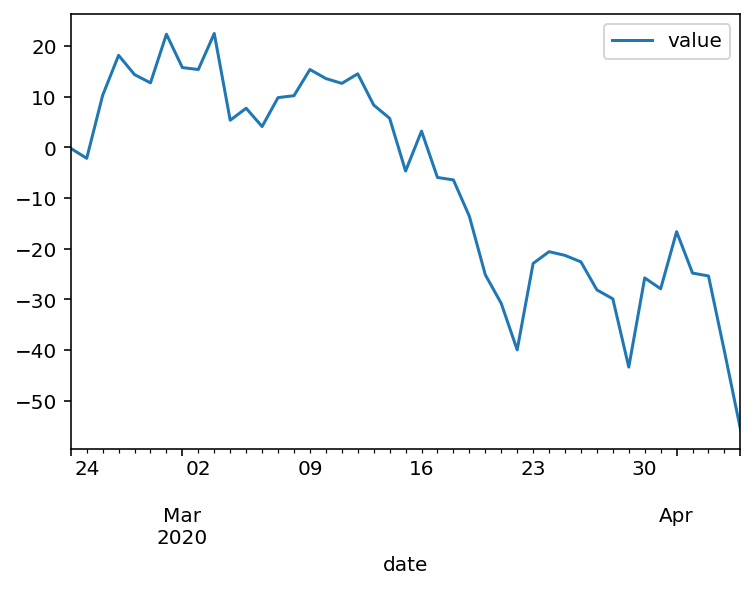

In [48]:
dates = pd.to_datetime(df.iloc[0]["dates"])
values = df.iloc[0]["values"]

pd.DataFrame().assign(date=pd.to_datetime(dates)).assign(value=values).set_index("date").plot()

In [49]:
# US will be included in the dataframe as a "state", and the states are "counties"
parse_state("US").head()

Parsed 306 plots for 51 counties in US


,state,county,category,change,changecalc,dates,values,page
0,US,Alabama,Retail & recreation,-50,-52.602667,"[2020-02-23, 2020-02-24, 2020-02-25, 2020-02-2...","[3.488, -2.063, 7.256, 16.242, 12.262, 12.831,...",2
1,US,Alabama,Grocery & pharmacy,-18,-18.286418,"[2020-02-23, 2020-02-24, 2020-02-25, 2020-02-2...","[2.189, -2.786, 2.912, 5.113, 5.9, 6.374, 10.1...",2
2,US,Alabama,Parks,-1,-1.446762,"[2020-02-23, 2020-02-24, 2020-02-25, 2020-02-2...","[24.939, -13.804, 28.125, 6.962, 14.381, 21.25...",2
3,US,Alabama,Transit stations,-40,-41.524150,"[2020-02-23, 2020-02-24, 2020-02-25, 2020-02-2...","[16.778, 1.793, 7.758, 11.511, 9.223, 10.421, ...",2
4,US,Alabama,Workplace,-36,-37.776197,"[2020-02-23, 2020-02-24, 2020-02-25, 2020-02-2...","[1.782, -2.127, -1.519, 0.487, 1.57, 0.634, 5....",2


In [50]:
import glob
states = [x.split("_US_",1)[1].split("_Mobility",1)[0] for x in glob.glob("pdfs/*.pdf")]
dfs = []
for state in states:
    try:
        parsed = parse_state(state)
    except:
        print(f"ERROR with {state}")
        continue
    dfs.append(parsed)
df = pd.concat(dfs).reset_index(drop=True)
data = []
for i,row in tqdm(df.iterrows()):
    # do a little clean up and unstack the dates/values as separate rows
    dorig = dict()
    dorig["state"] = row["state"].replace("_"," ")
    dorig["county"] = row["county"]
    dorig["category"] = row["category"].replace(" & ","/").replace(" ","").lower()
    dorig["page"] = row["page"]
    dorig["change"] = row["change"]
    dorig["changecalc"] = row["changecalc"]
    for x,y in zip(row["dates"],row["values"]):
        d = dorig.copy()
        d["date"] = x
        d["value"] = y
        data.append(d)
df = pd.DataFrame(data)
df.to_json("data/data.json.gz", orient="records", indent=2)

Parsed 23 plots for 4 counties in Hawaii
Parsed 28 plots for 8 counties in Nevada
Parsed 64 plots for 24 counties in Nebraska
Parsed 221 plots for 68 counties in Illinois
Parsed 128 plots for 33 counties in South_Carolina
Parsed 219 plots for 66 counties in Indiana
Parsed 35 plots for 11 counties in Wyoming
Parsed 50 plots for 9 counties in Massachusetts
Parsed 163 plots for 54 counties in Mississippi
Parsed 339 plots for 103 counties in Georgia
Parsed 163 plots for 54 counties in Mississippi
Parsed 193 plots for 71 counties in Kentucky
Parsed 283 plots for 92 counties in Virginia
Parsed 531 plots for 150 counties in Texas
Parsed 24 plots for 8 counties in North_Dakota
Parsed 31 plots for 8 counties in New_Hampshire
Parsed 95 plots for 23 counties in Oregon
Parsed 273 plots for 71 counties in Ohio
Parsed 159 plots for 48 counties in Louisiana
Parsed 185 plots for 55 counties in Alabama
Parsed 86 plots for 29 counties in West_Virginia
Parsed 273 plots for 71 counties in Ohio
Parsed 136 

In [51]:
dfc = pd.read_json("data/data.json.gz")
dfc["date"] = pd.to_datetime(dfc["date"])

In [52]:
len(dfc)

596628

In [53]:
dfc["category"].value_counts()

retail/recreation    157658
grocery/pharmacy     152512
workplace            137312
transitstations       62850
residential           48304
parks                 37992
Name: category, dtype: int64

Text(0.5, 1.0, 'workplace for New York counties')

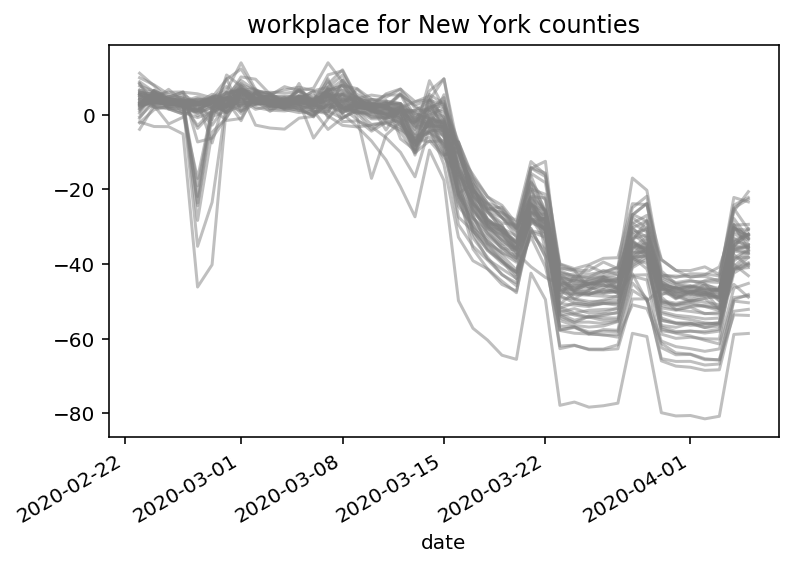

In [54]:
fig, ax = plt.subplots()
state = "New York"
category = "workplace"
dfc[(dfc["state"]==state) & (dfc["category"]==category)].set_index("date").groupby("county")["value"].plot(
    ax=ax,color="gray",
    alpha=0.5,
);
ax.set_title(f"{category} for {state} counties")

# Debug

In [41]:
df = parse_state("Kansas", verbose=True)

ipage: 2
2
{'Allen County': {'Retail & recreation': -28, 'Grocery & pharmacy': -2}, 'Anderson County': {}}
1
ipage: 3
4
{'Atchison County': {'Retail & recreation': -20}, 'Barton County': {'Retail & recreation': -31, 'Grocery & pharmacy': -16, 'Workplace': -24}}
4
ipage: 4
3
{'Bourbon County': {'Retail & recreation': -37, 'Grocery & pharmacy': -15}, 'Brown County': {'Retail & recreation': -18}}
3
ipage: 5
6
{'Butler County': {'Retail & recreation': -36, 'Grocery & pharmacy': -21, 'Workplace': -30}, 'Cherokee County': {'Retail & recreation': -24, 'Grocery & pharmacy': 5, 'Workplace': -33}}
6
ipage: 6
1
{'Clay County': {}, 'Cloud County': {'Retail & recreation': -47}}
1
ipage: 7
4
{'Coffey County': {'Transit stations': -26}, 'Cowley County': {'Retail & recreation': -35, 'Grocery & pharmacy': -20, 'Workplace': -35}}
4
ipage: 8
6
{'Crawford County': {'Retail & recreation': -46, 'Grocery & pharmacy': -28, 'Workplace': -23}, 'Dickinson County': {'Retail & recreation': -44, 'Grocery & pharmacy